# Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (20, 13)
%matplotlib inline
%config InlineBackend.figure_format = "retina"

## Loading the data into panda dataframes

In [3]:
rootpath="../data_final_project/KuaiRec/"

big_matrix = pd.read_csv(rootpath + "data/big_matrix.csv")
item_categories = pd.read_csv(rootpath + "data/item_categories.csv")
item_daily_features = pd.read_csv(rootpath + "data/item_daily_features.csv")
kuairec_caption_category = pd.read_csv(rootpath + "data/kuairec_caption_category.csv", engine="python", sep=",", quotechar='"', on_bad_lines='skip')
small_matrix = pd.read_csv(rootpath + "data/small_matrix.csv")
social_network = pd.read_csv(rootpath + "data/social_network.csv")
user_features = pd.read_csv(rootpath + "data/user_features.csv")

## Cleaning data


Before diving into the analysis or feature engineering, we start by ensuring that our dataset is clean and consistent. This step includes:

- Checking for **null values**
- Removing any **duplicate records**
- Modify/Remove columns if **unnecessary or redudant**

Cleaning the data properly is essential for building reliable and meaningful features later on.

In [4]:
small_matrix.dropna(inplace=True)
big_matrix.dropna(inplace=True)
item_categories.dropna(inplace=True)
user_features.dropna(inplace=True)
item_daily_features.dropna(inplace=True)
kuairec_caption_category.dropna(inplace=True)
social_network.dropna(inplace=True)

small_matrix = small_matrix.drop(columns=['date'])
big_matrix = big_matrix.drop(columns=['date'])
small_matrix = small_matrix.drop(columns=['timestamp'])
big_matrix = big_matrix.drop(columns=['timestamp'])


In [5]:
small_matrix.drop_duplicates(subset=["video_id", "user_id"],inplace=True)
big_matrix.drop_duplicates(subset=["video_id", "user_id"],inplace=True)
user_features.drop_duplicates(subset=["user_id"], inplace=True)
item_daily_features.drop_duplicates(subset=["video_id", "date"],inplace=True)
kuairec_caption_category.drop_duplicates(subset=["video_id"],inplace=True)
social_network.drop_duplicates(subset=["user_id", "friend_list"],inplace=True)

## Inspecting interactions

Small_matrix and big_matrix have the same structure. They correspond to interactions_test.csv and interactions_train.csv respectively

Number of unique videos: 10728
Number of unique users: 7176
Average watch ratio: 0.9603665212079732
Median watch ratio: 0.7372108728684789
Max watch ratio: 573.4571428571429
Sparsity of the big matrix: 0.8662
Sparsity of the small matrix: 0.0426


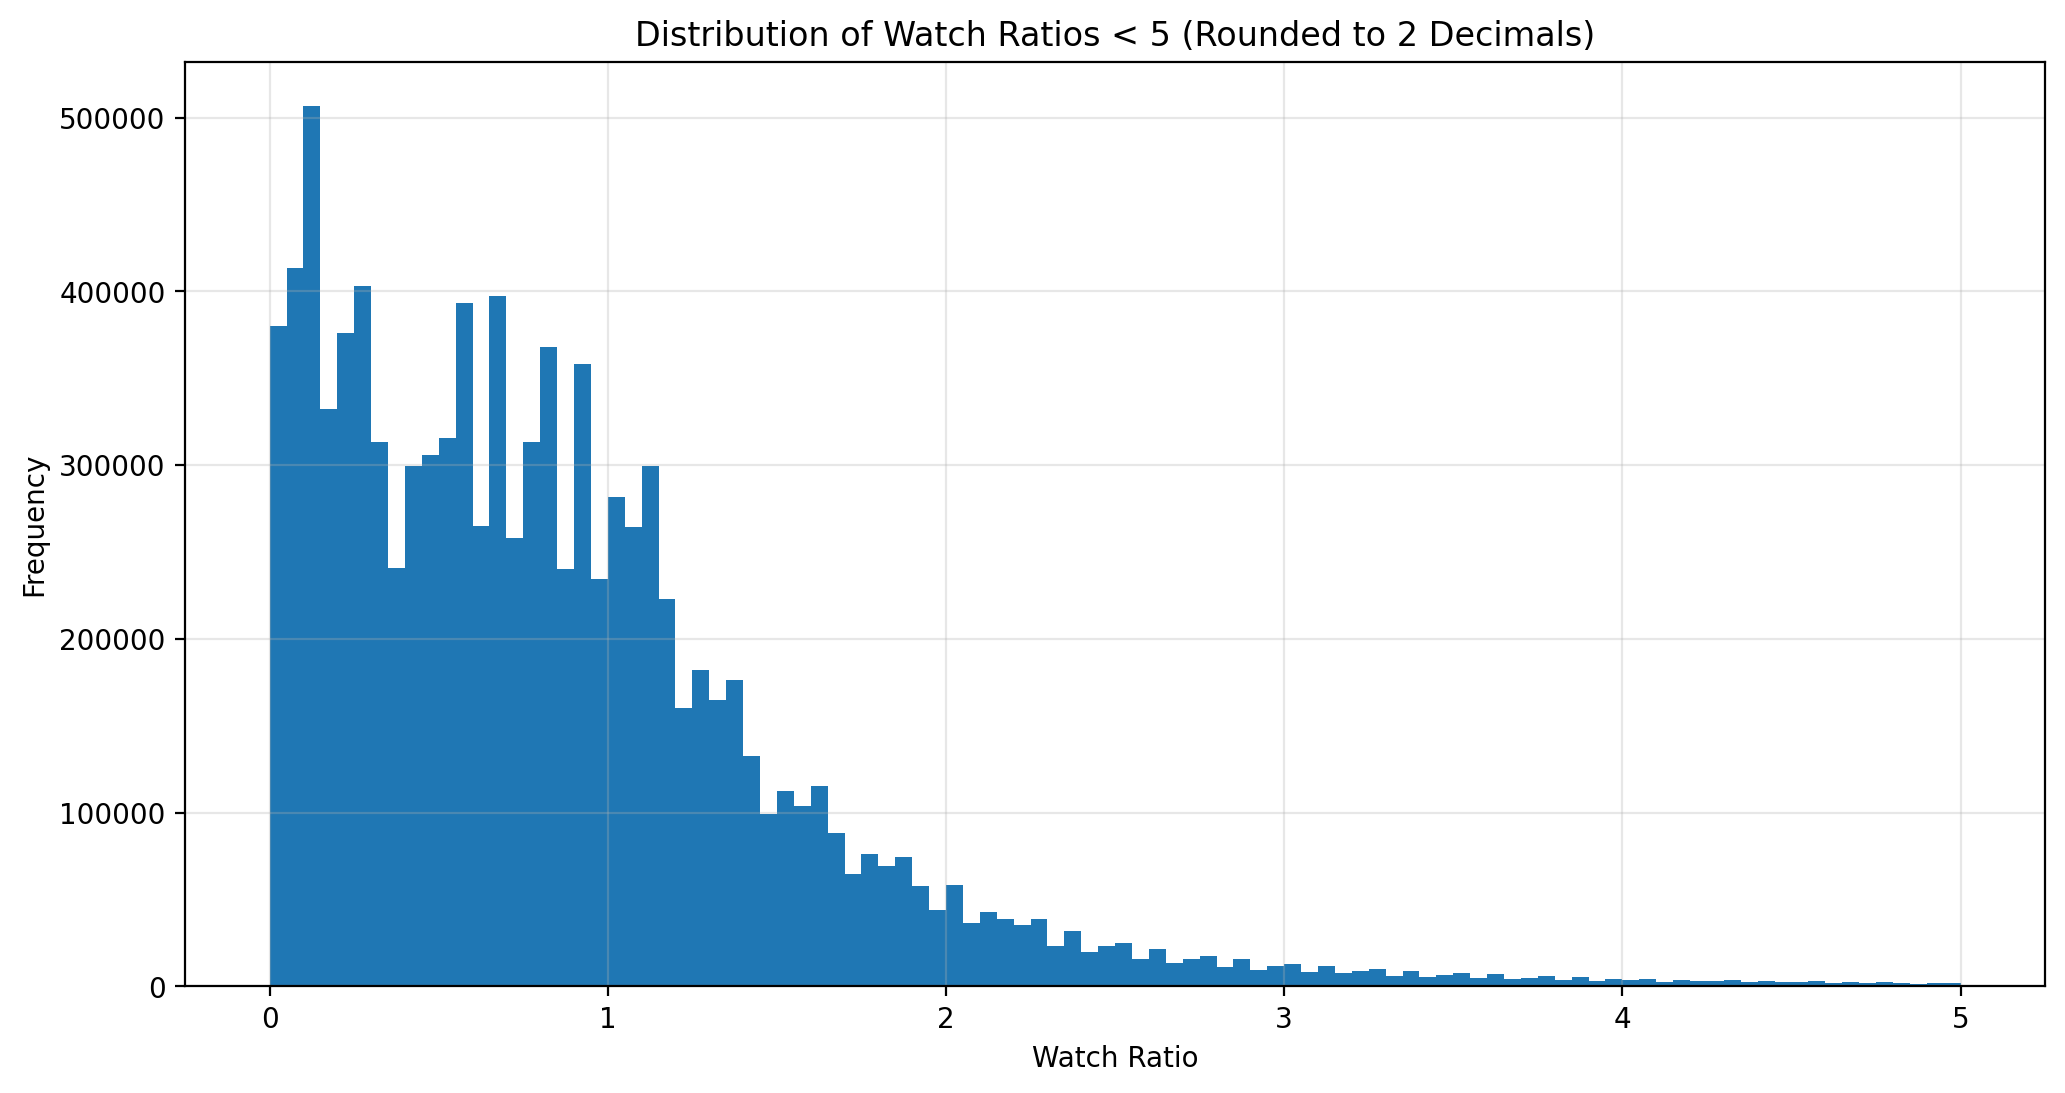

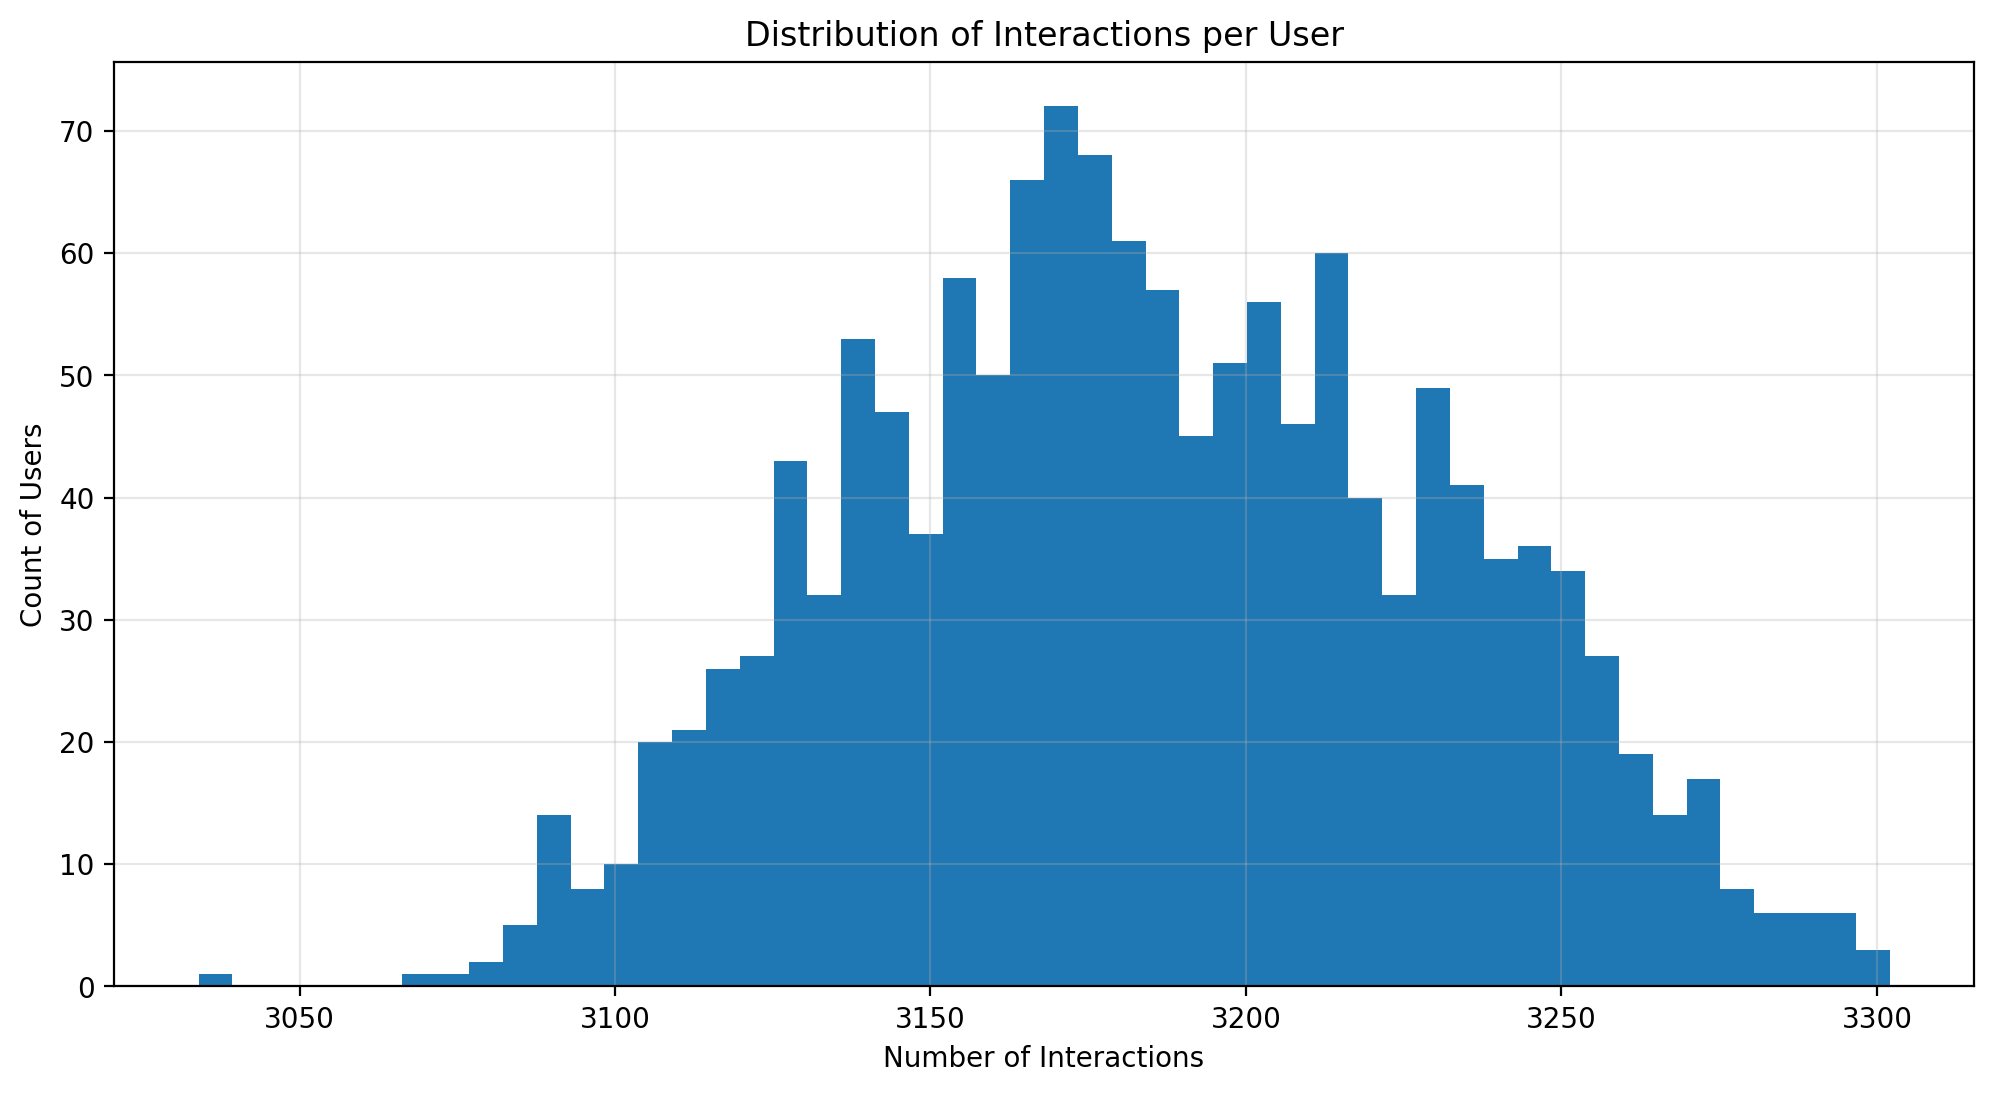

In [6]:
# Convert and clean
watch_ratios = big_matrix["watch_ratio"].astype(float)
watch_ratios = watch_ratios.replace([np.inf, -np.inf], np.nan).dropna()

# --- Some general stats about the interactions user/videos ---
print("Number of unique videos:", big_matrix['video_id'].nunique())
print("Number of unique users:", big_matrix['user_id'].nunique())
print("Average watch ratio:", watch_ratios.mean())
print("Median watch ratio:", watch_ratios.median())
print("Max watch ratio:", watch_ratios.max())

n_users = big_matrix['user_id'].nunique()
n_items = big_matrix['video_id'].nunique()
sparsity = 1 - (len(big_matrix) / (n_users * n_items))
print(f"Sparsity of the big matrix: {sparsity:.4f}")

n_users = small_matrix['user_id'].nunique()
n_items = small_matrix['video_id'].nunique()
sparsity = 1 - (len(small_matrix) / (n_users * n_items))
print(f"Sparsity of the small matrix: {sparsity:.4f}")

# --- Histogram of ratios under 5 ---
# This makes sense as it is where most ratios are
filtered_ratios = watch_ratios[watch_ratios < 5].round(2)
counts_filtered = filtered_ratios.value_counts().sort_index()

plt.figure(figsize=(12, 6))
plt.hist(filtered_ratios, bins=100)
plt.title("Distribution of Watch Ratios < 5 (Rounded to 2 Decimals)")
plt.xlabel("Watch Ratio")
plt.ylabel("Frequency")
plt.grid(True, alpha=0.3)
plt.show()

# --- Histogram of interaction per user ---
user_counts = small_matrix["user_id"].value_counts()

plt.figure(figsize=(12, 6))
plt.hist(user_counts, bins=50)
plt.title("Distribution of Interactions per User")
plt.xlabel("Number of Interactions")
plt.ylabel("Count of Users")
plt.grid(True, alpha=0.3)
plt.show()


## Inspecting item categories

This files links videos with one or multiple features aka 'type' of video. Each video_id is unique 

Types in 'video_id':
video_id
<class 'int'>    10728
Name: count, dtype: int64 

Initial type in 'feat':
feat
<class 'list'>    10728
Name: count, dtype: int64 

Potentially modified type in 'feat':
feat
<class 'list'>    10728
Name: count, dtype: int64 

Number of unique videos: 10728
Average number of features per video: 1.18


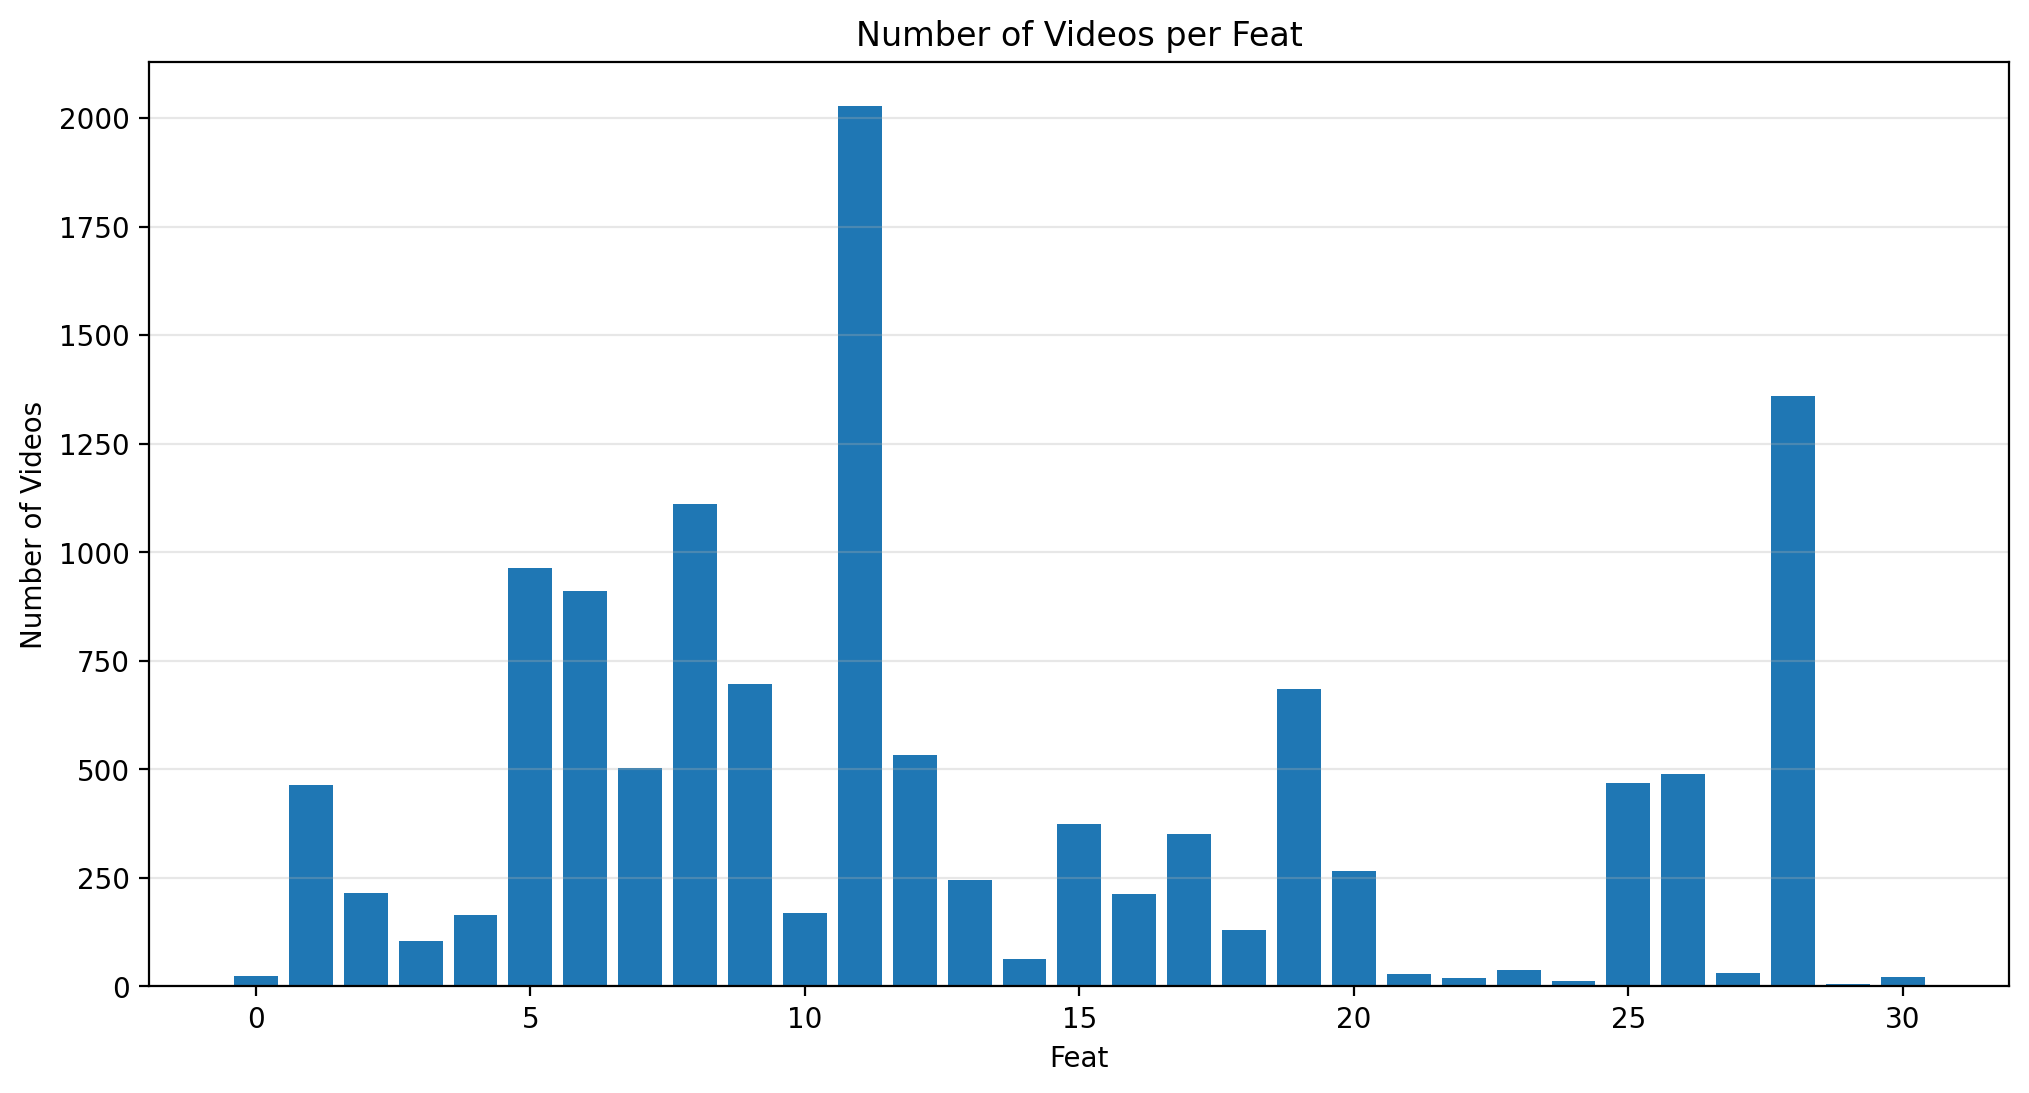

In [8]:
types = item_categories['video_id'].map(type).value_counts()
print("Types in 'video_id':")
print(types, '\n')

types = item_categories['feat'].map(type).value_counts()
print("Initial type in 'feat':")
print(types, '\n')

# Cleaning the feat column as it is initially of type str and turn into type list
if item_categories['feat'].apply(lambda x: isinstance(x, list)).mean() < 1.0:
    # if all elements of column feat are list we don't go in this condition
    item_categories['feat'] = item_categories['feat'].str.strip('[]').str.split(',')
types = item_categories['feat'].map(type).value_counts()
print("Potentially modified type in 'feat':")
print(types, '\n')

print("Number of unique videos:", item_categories['video_id'].nunique())
print("Average number of features per video:", round( item_categories['feat'].apply(len).mean(), 2))

# Explode the feat column to get one category per row
exploded_feats = item_categories.explode('feat')

# removing whitespace to turn the list of string into ints
exploded_feats['feat'] = exploded_feats['feat'].astype(str).str.strip()
exploded_feats = exploded_feats[exploded_feats['feat'].str.isdigit()]
exploded_feats['feat'] = exploded_feats['feat'].astype(int)

category_counts = exploded_feats['feat'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
plt.bar(category_counts.index, category_counts.values)
plt.xlabel("Feat")
plt.ylabel("Number of Videos")
plt.title("Number of Videos per Feat")
plt.grid(axis='y', alpha=0.3)
plt.show()

## Inspecting item daily features
This file contains a lot of informations. Each line is a day (among a 63 days period) of data from a specific video. Since there is a lot of column we only keep the one that could turn useful. These periodic data could help us later on to define how "viral" a video is recently.

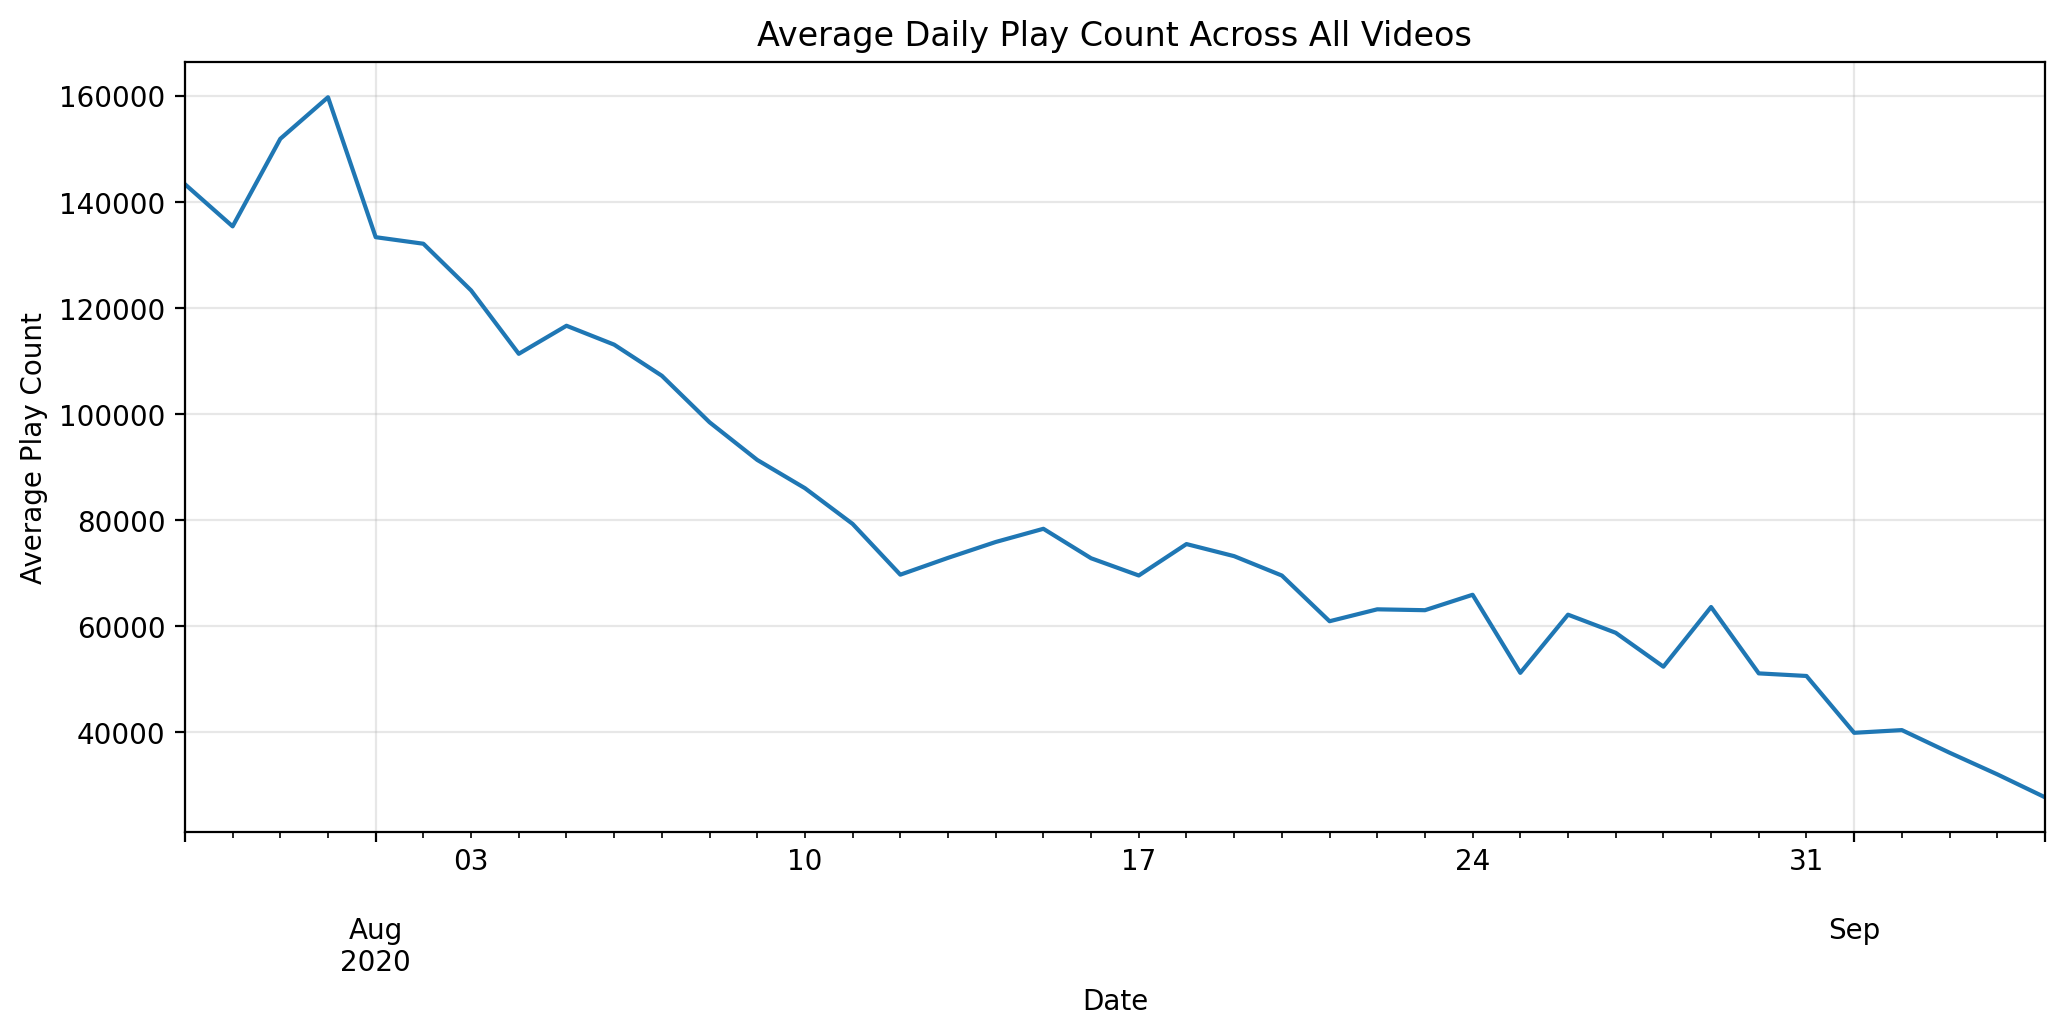

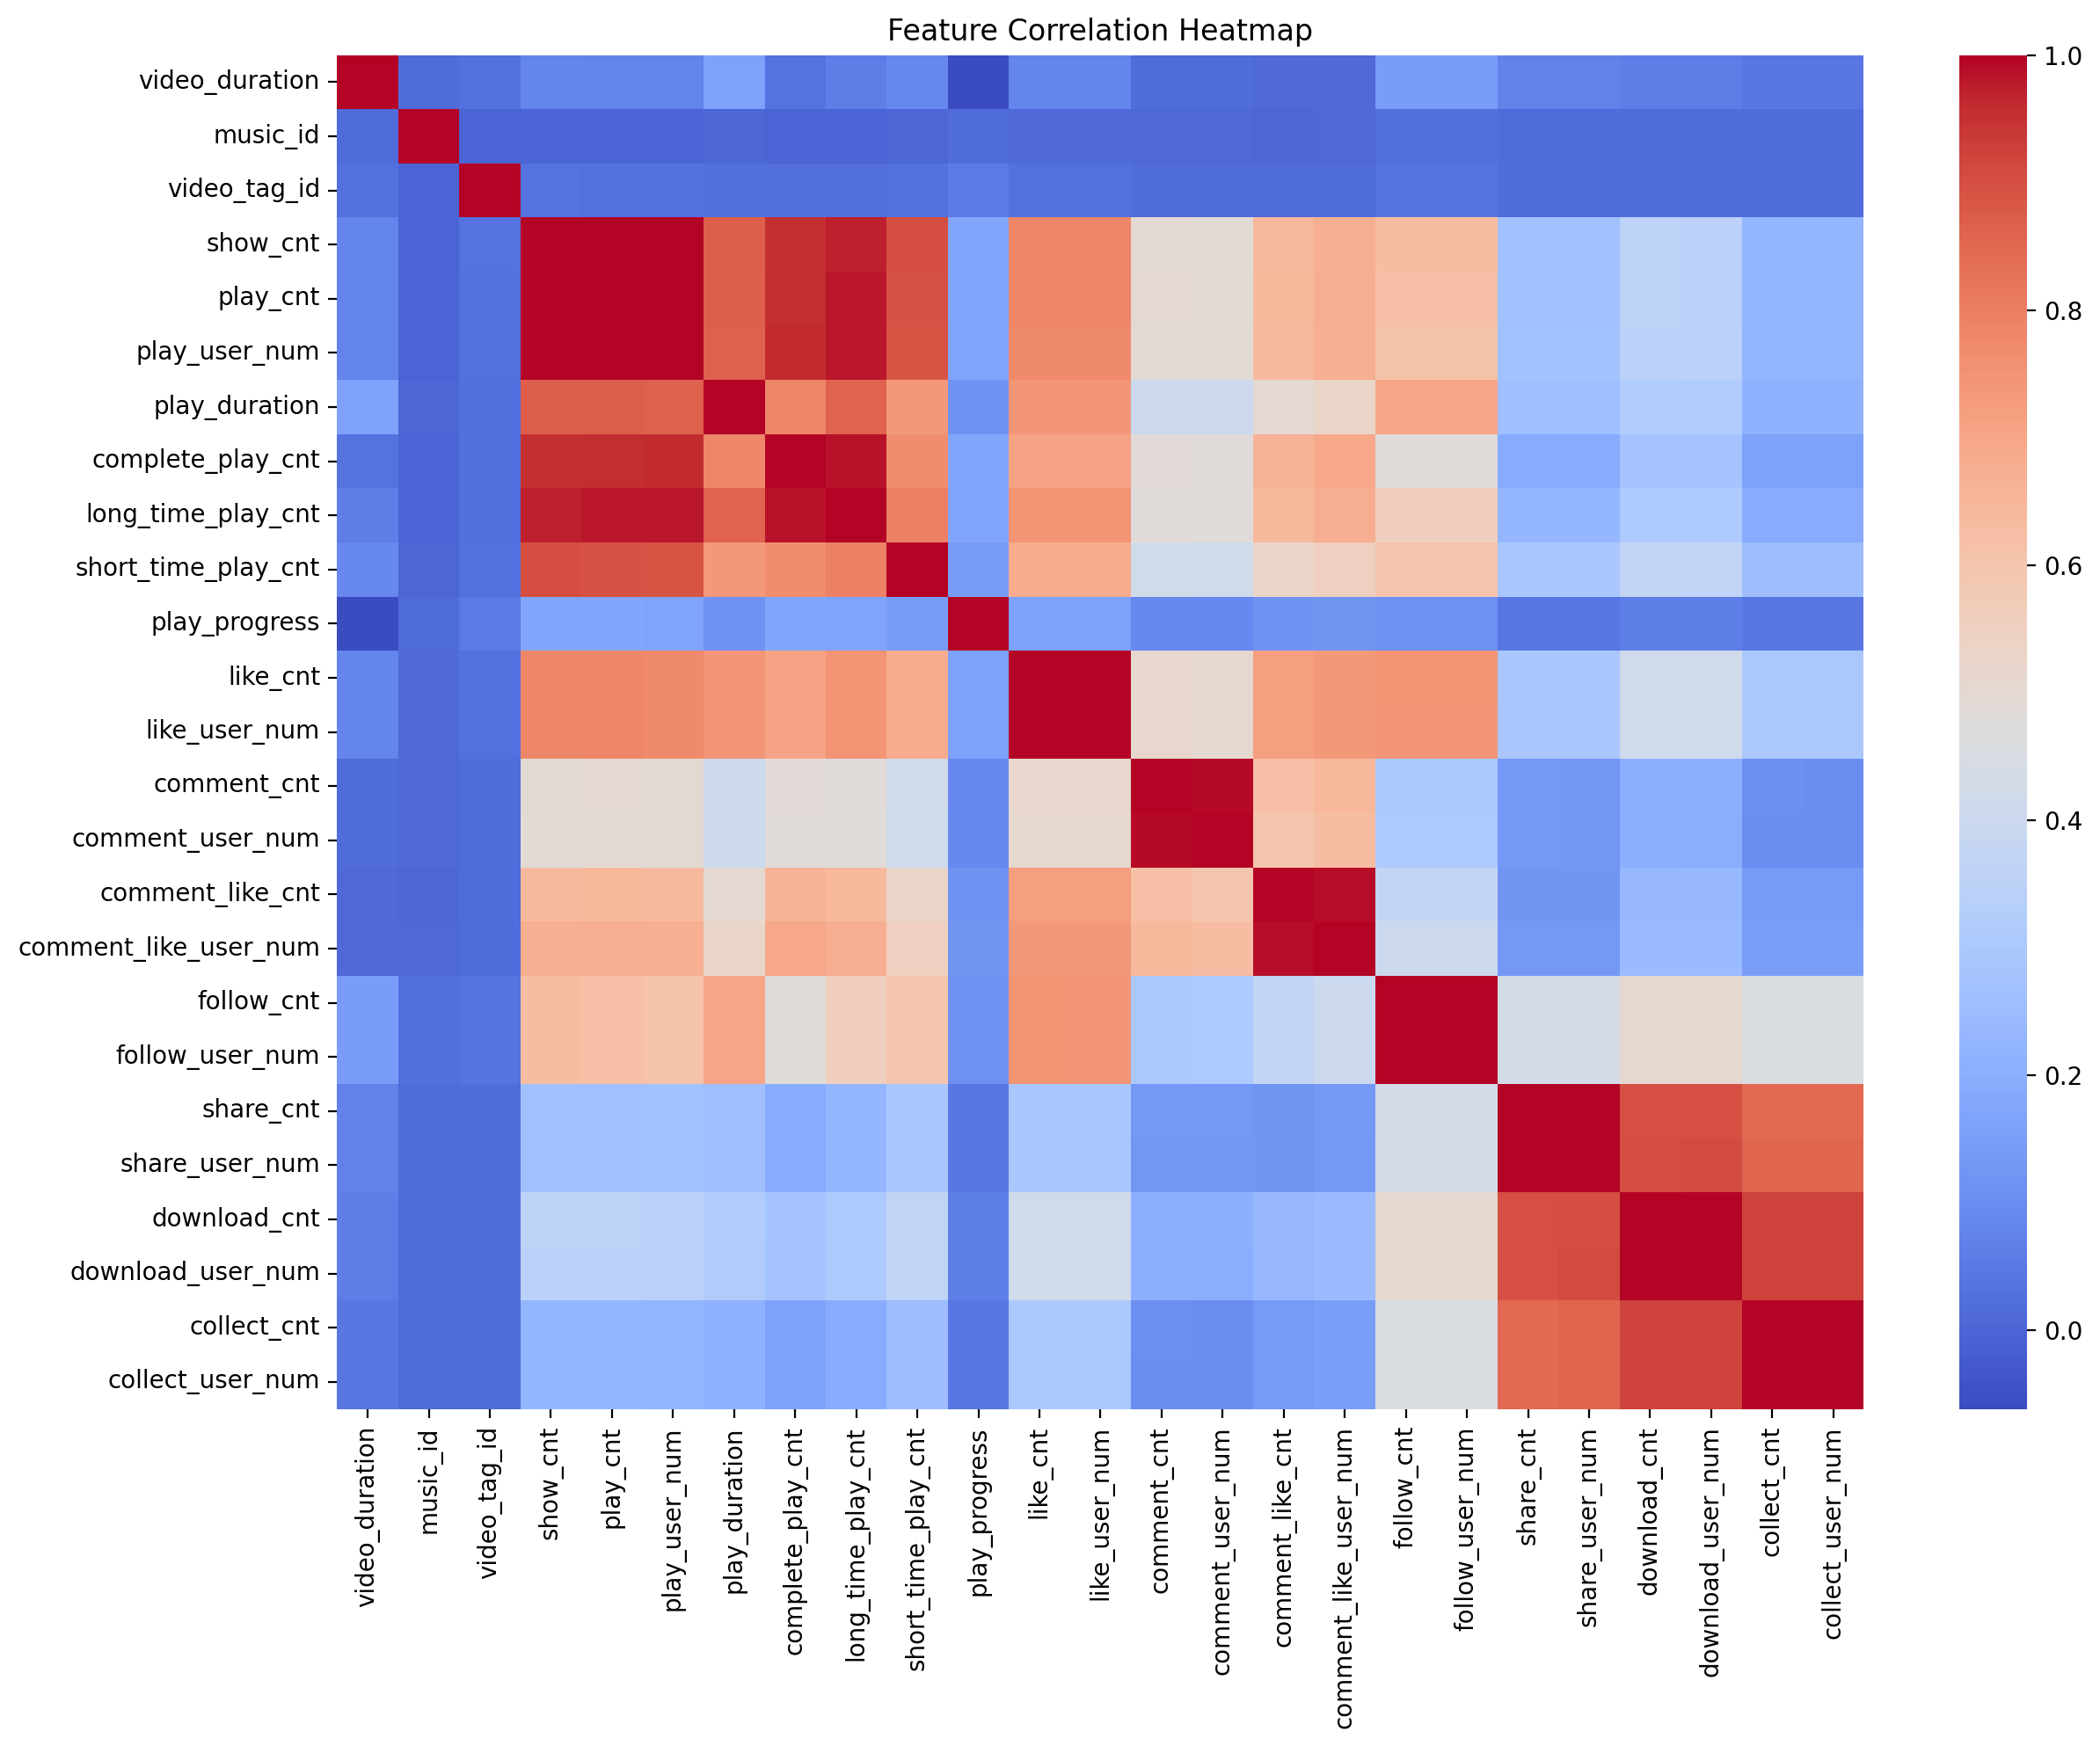

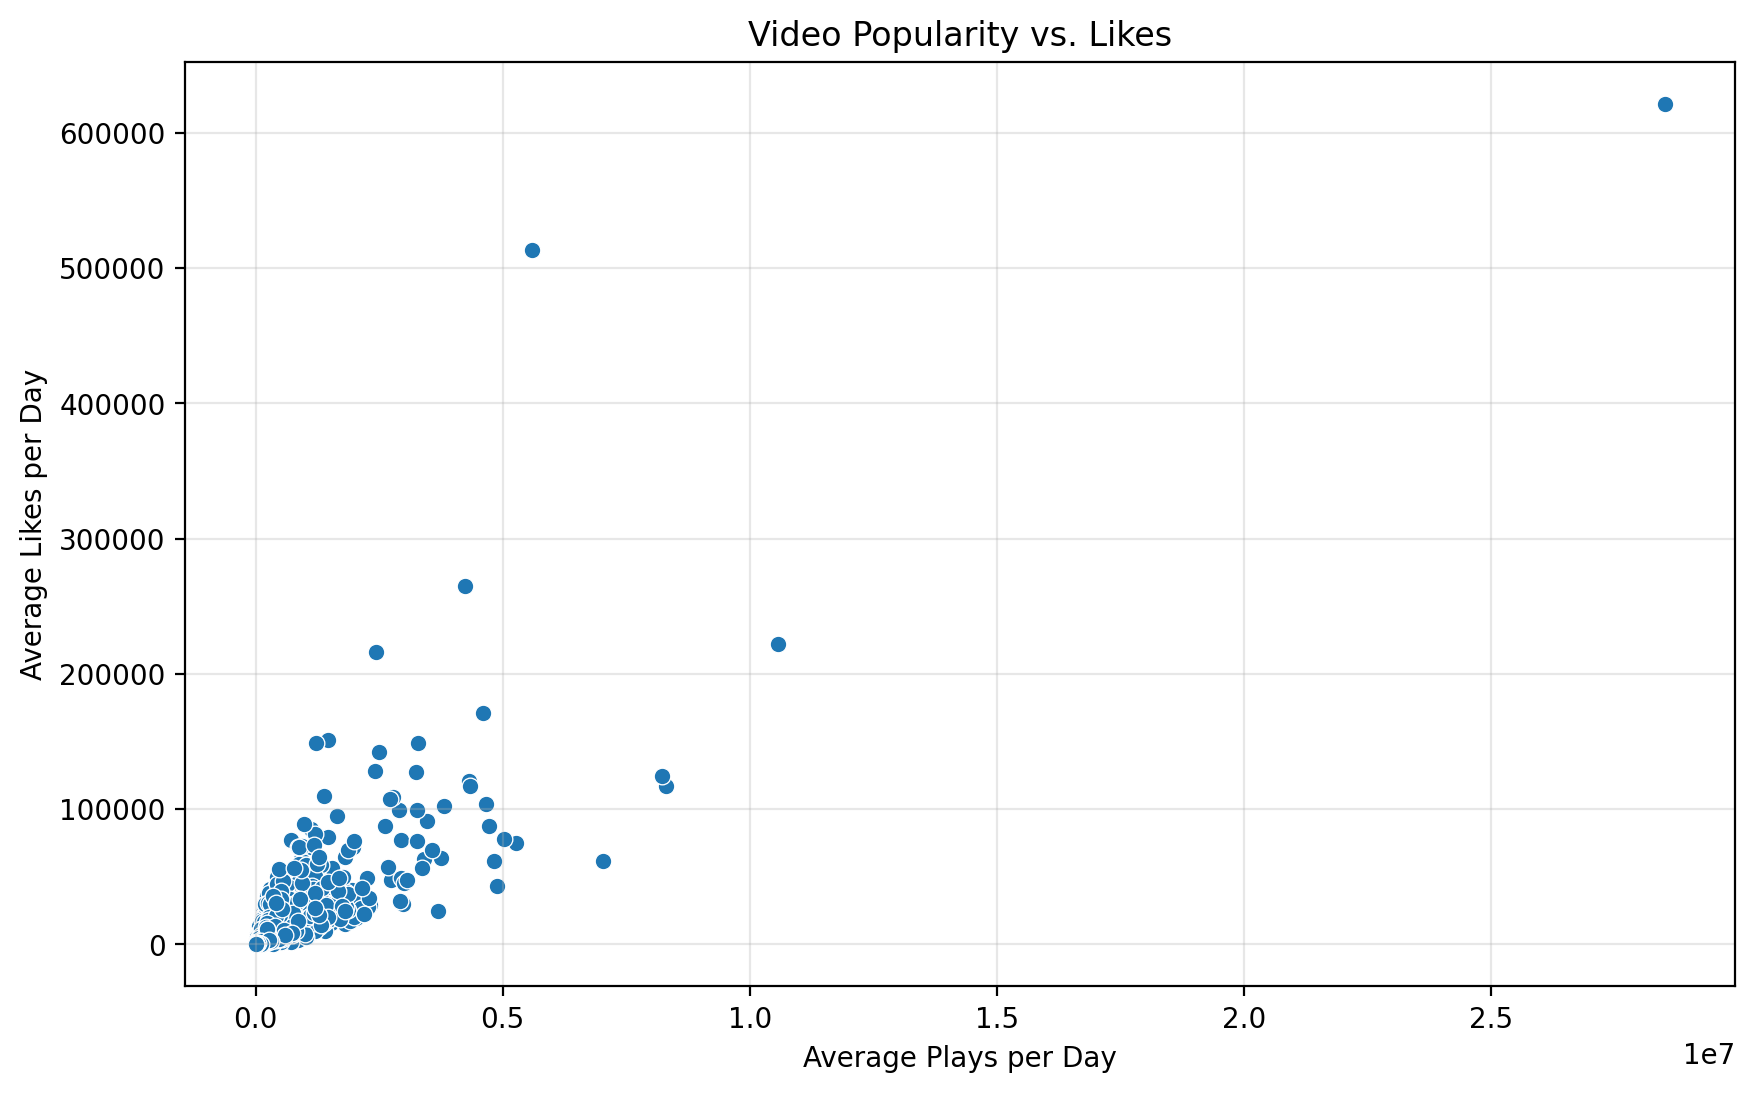

In [9]:
useful_columns = [
    'video_id',
    'author_id',
    'date',
    'video_duration',
    'music_id',
    'video_tag_id',
    'show_cnt', #number of times video was shown
    'play_cnt', #total number of plays
    'play_user_num', #number of users who watched it
    'play_duration', #Total play time accumulated
    'complete_play_cnt', #number of times the videos was completly watched
    'long_time_play_cnt', #Number of long-duration plays
    'short_time_play_cnt', #Number of short plays (e.g., skip/abandon)
    'play_progress', #average watch ratio
    'like_cnt', #number of likes 
    'like_user_num', #number of users who liked
    'comment_cnt', #number of comments
    'comment_user_num', #number of users who liekd 
    'comment_like_cnt', #number of likes on comments
    'comment_like_user_num', #Unique users who liked comments
    'follow_cnt', #Number of times the video's viewers followed the author
    'follow_user_num', #Unique users who followed the author from this video
    'share_cnt', #number of shares
    'share_user_num', #	Unique users who shared it
    'download_cnt', #number of download
    'download_user_num', #Unique users who downloaded it
    'collect_cnt', #Number of times the video was added to collections/favorites
    'collect_user_num', #Unique users who collected/favorited it
]
#pd.set_option('display.max_columns', None)
#pd.set_option('display.width', 0) 
item_daily_features2 = item_daily_features[useful_columns]
item_daily_features2.head(5)

#Cleaning the date column from int to date type
item_daily_features2 = item_daily_features[useful_columns].copy()
item_daily_features2['date'] = pd.to_datetime(item_daily_features2['date'].astype(str), format='%Y%m%d')

#We try and check if average daily play is regular
daily_avg = item_daily_features2.groupby('date')['play_cnt'].mean()
plt.figure(figsize=(12, 5))
daily_avg.plot()
plt.title('Average Daily Play Count Across All Videos')
plt.xlabel('Date')
plt.ylabel('Average Play Count')
plt.grid(True, alpha=0.3)
plt.show()

# We check if like_cnt strongly correlate with follow_cnt or share_cnt or  play_cnt and play_duration
corr = item_daily_features2.drop(columns=['video_id', 'author_id', 'date']).corr()
plt.figure(figsize=(14, 10))
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title('Feature Correlation Heatmap')
plt.show()

#Check if more views usually means more likes
avg_engagement = item_daily_features2.groupby('video_id')[['play_cnt', 'like_cnt', 'comment_cnt', 'share_cnt']].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.scatterplot(data=avg_engagement, x='play_cnt', y='like_cnt')
plt.xlabel('Average Plays per Day')
plt.ylabel('Average Likes per Day')
plt.title('Video Popularity vs. Likes')
plt.grid(True, alpha=0.3)
plt.show()

## Inspecting caption category
This file contains a lot of informations. We remove all unecessary and end up with the three main category of videos in order.

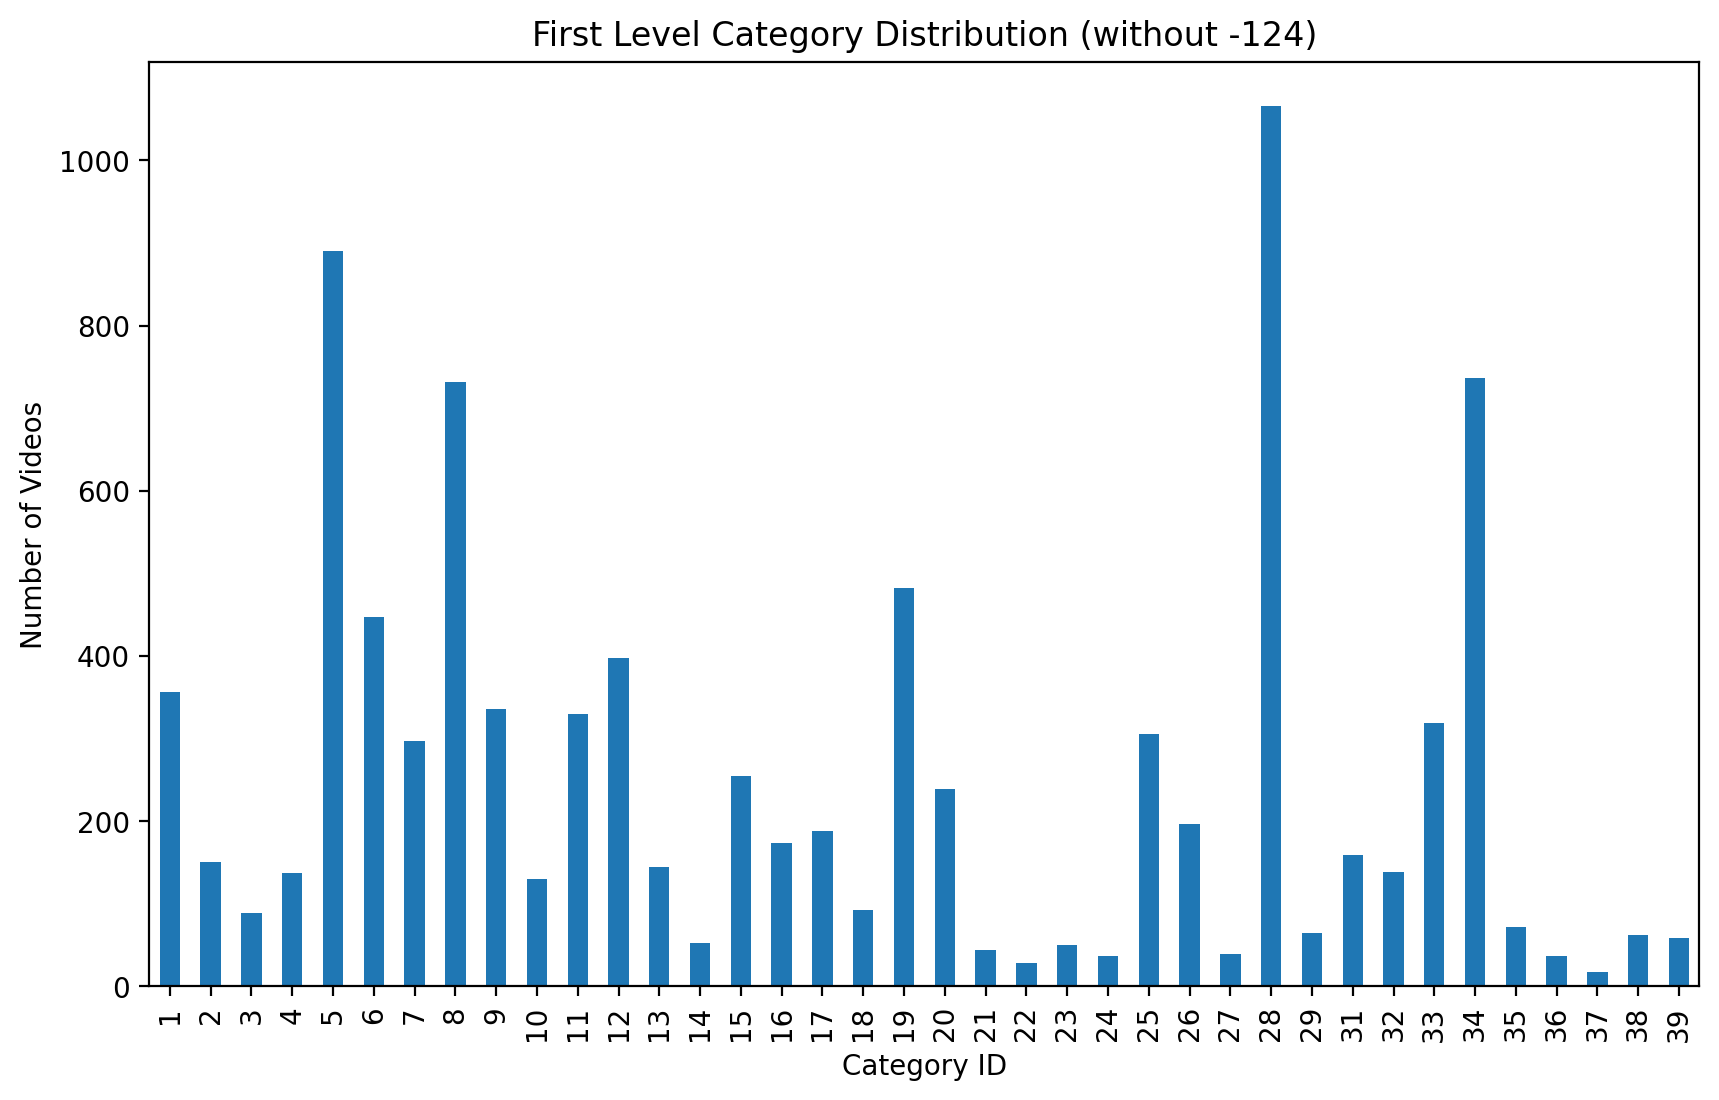

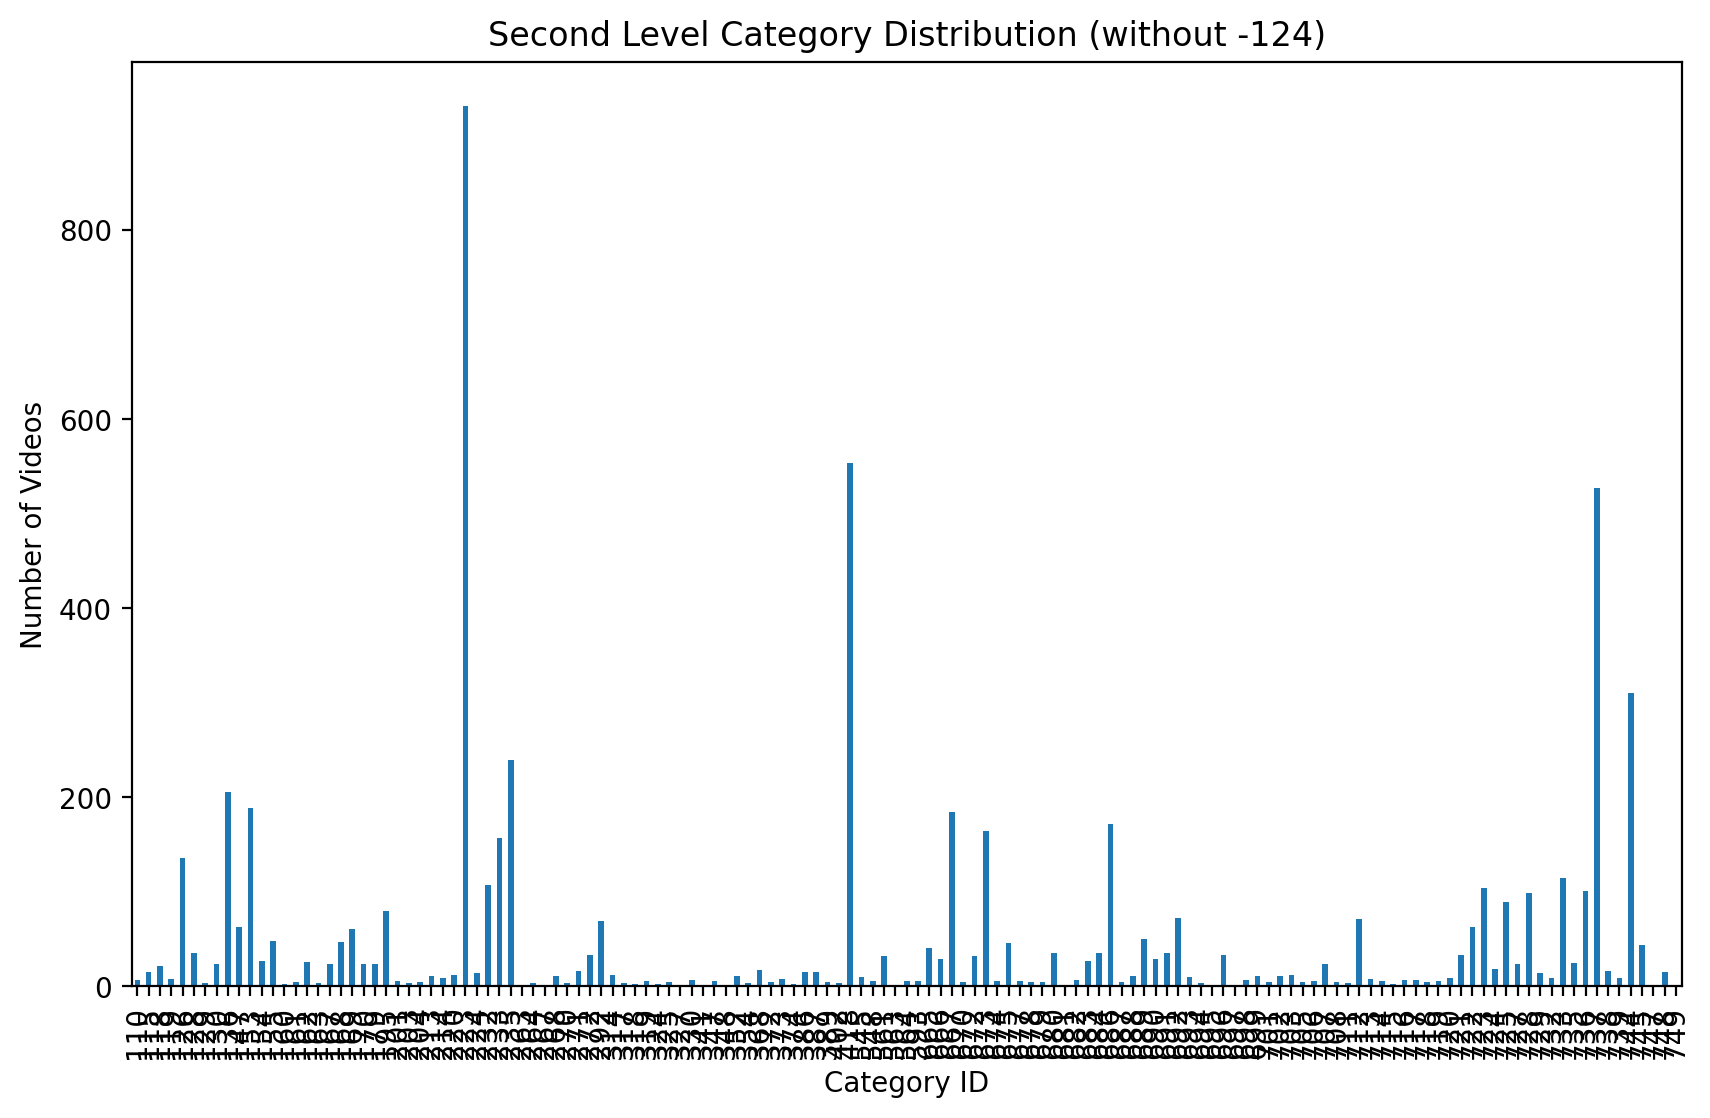

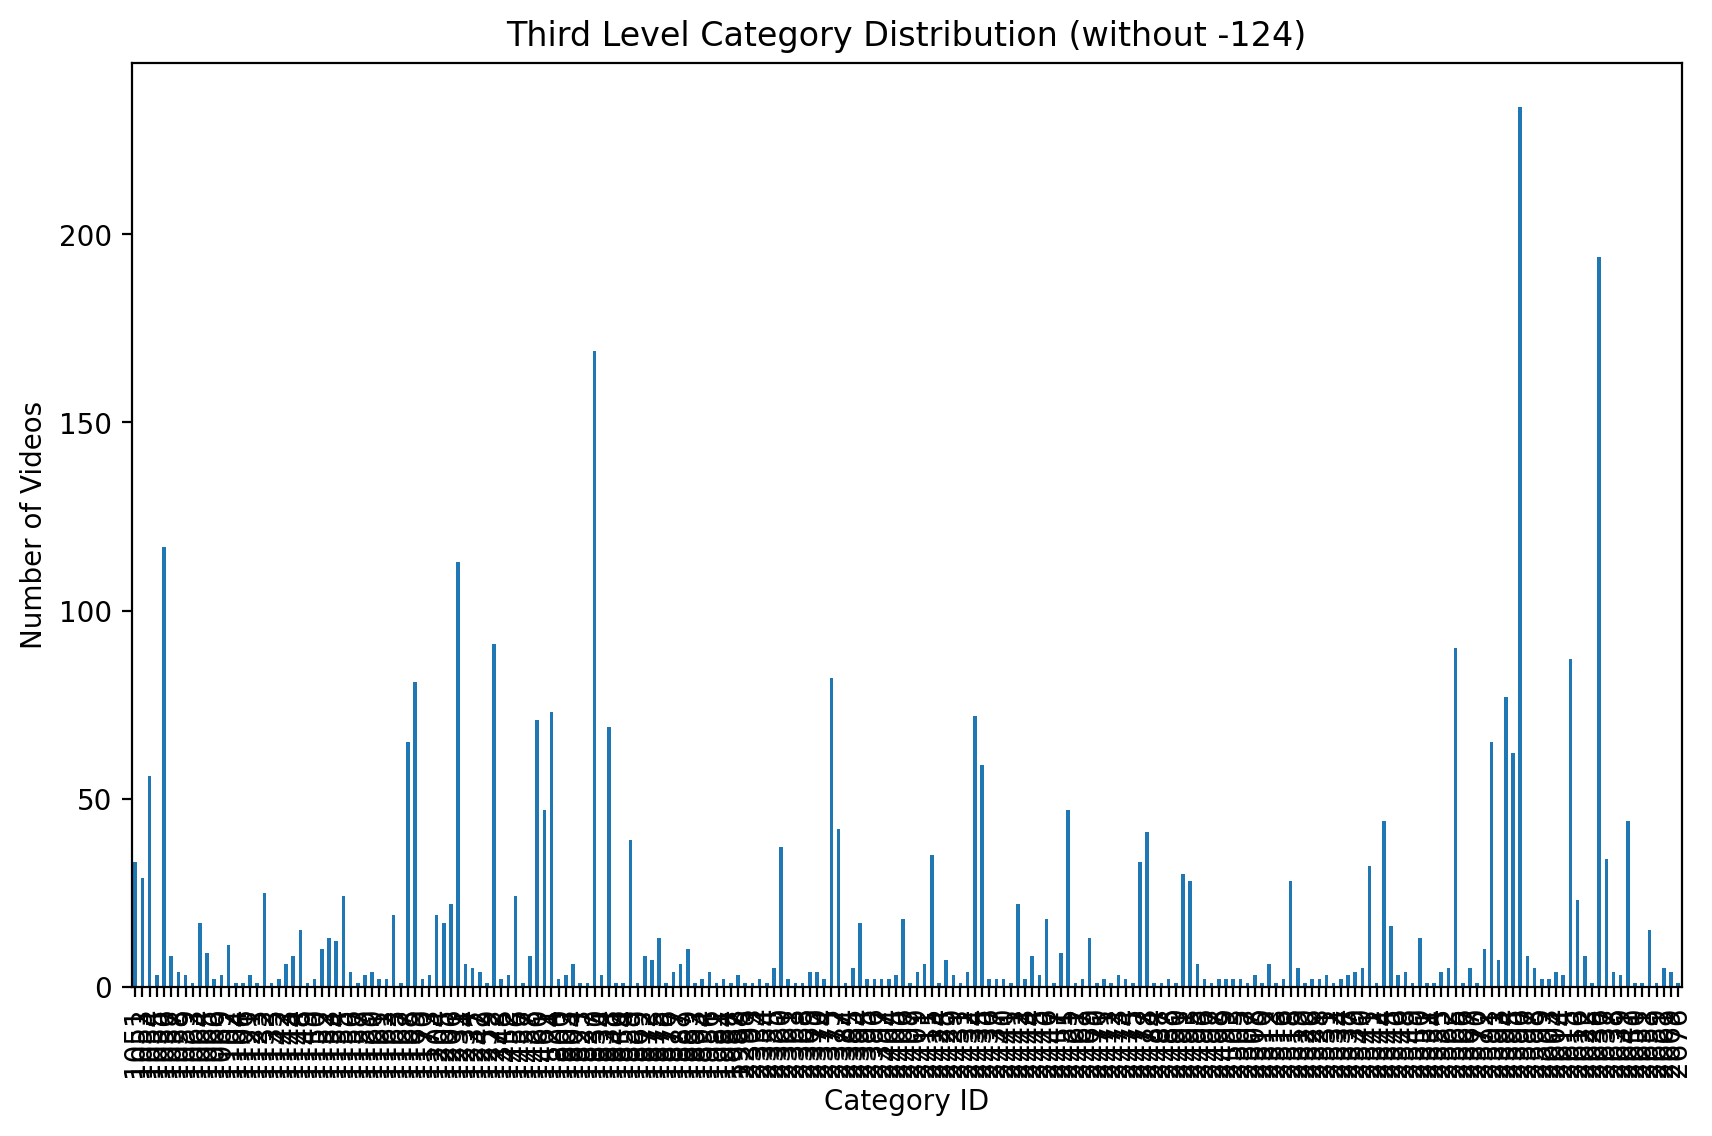

In [10]:
# --- Cleaning data ---

#only keeping the column that could be relevant
columns_to_drop = [
    'manual_cover_text', 'caption', 'topic_tag',
    'first_level_category_name', 'second_level_category_name', 'third_level_category_name'
]
#kuairec_caption_category = kuairec_caption_category.drop(columns=columns_to_drop)

#cleaning level_category_id to go from float to int as it is an id
#note: -124 is considered UNASSIGNED or UNKNOWN
kuairec_caption_category['first_level_category_id'] = kuairec_caption_category['first_level_category_id'].astype('Int64')
kuairec_caption_category['second_level_category_id'] = kuairec_caption_category['second_level_category_id'].astype('Int64')
kuairec_caption_category['third_level_category_id'] = kuairec_caption_category['third_level_category_id'].astype('Int64')



# --- Analysing data ---

# histogram of  each level of categories

# Removing the -124
first_level = kuairec_caption_category[
    (kuairec_caption_category['first_level_category_id'] != -124) & 
    kuairec_caption_category['first_level_category_id'].notna()
]['first_level_category_id'].astype(int)
second_level = kuairec_caption_category[
    (kuairec_caption_category['second_level_category_id'] != -124) & 
    kuairec_caption_category['second_level_category_id'].notna()
]['second_level_category_id'].astype(int)
third_level = kuairec_caption_category[
    (kuairec_caption_category['third_level_category_id'] != -124) & 
    kuairec_caption_category['third_level_category_id'].notna()
]['third_level_category_id'].astype(int)

plt.figure(figsize=(10, 6))
first_level.value_counts().sort_index().plot(kind='bar')
plt.title('First Level Category Distribution (without -124)')
plt.xlabel('Category ID')
plt.ylabel('Number of Videos')
plt.show()

plt.figure(figsize=(10, 6))
second_level.value_counts().sort_index().plot(kind='bar')
plt.title('Second Level Category Distribution (without -124)')
plt.xlabel('Category ID')
plt.ylabel('Number of Videos')
plt.show()

plt.figure(figsize=(10, 6))
third_level.value_counts().sort_index().plot(kind='bar')
plt.title('Third Level Category Distribution (without -124)')
plt.xlabel('Category ID')
plt.ylabel('Number of Videos')
plt.show()

## Inspecting social network
In this file each user is associated to a list of friends

Average friends in list: 1.42
Median  friends in list: 1.0
Max  friends in list: 5


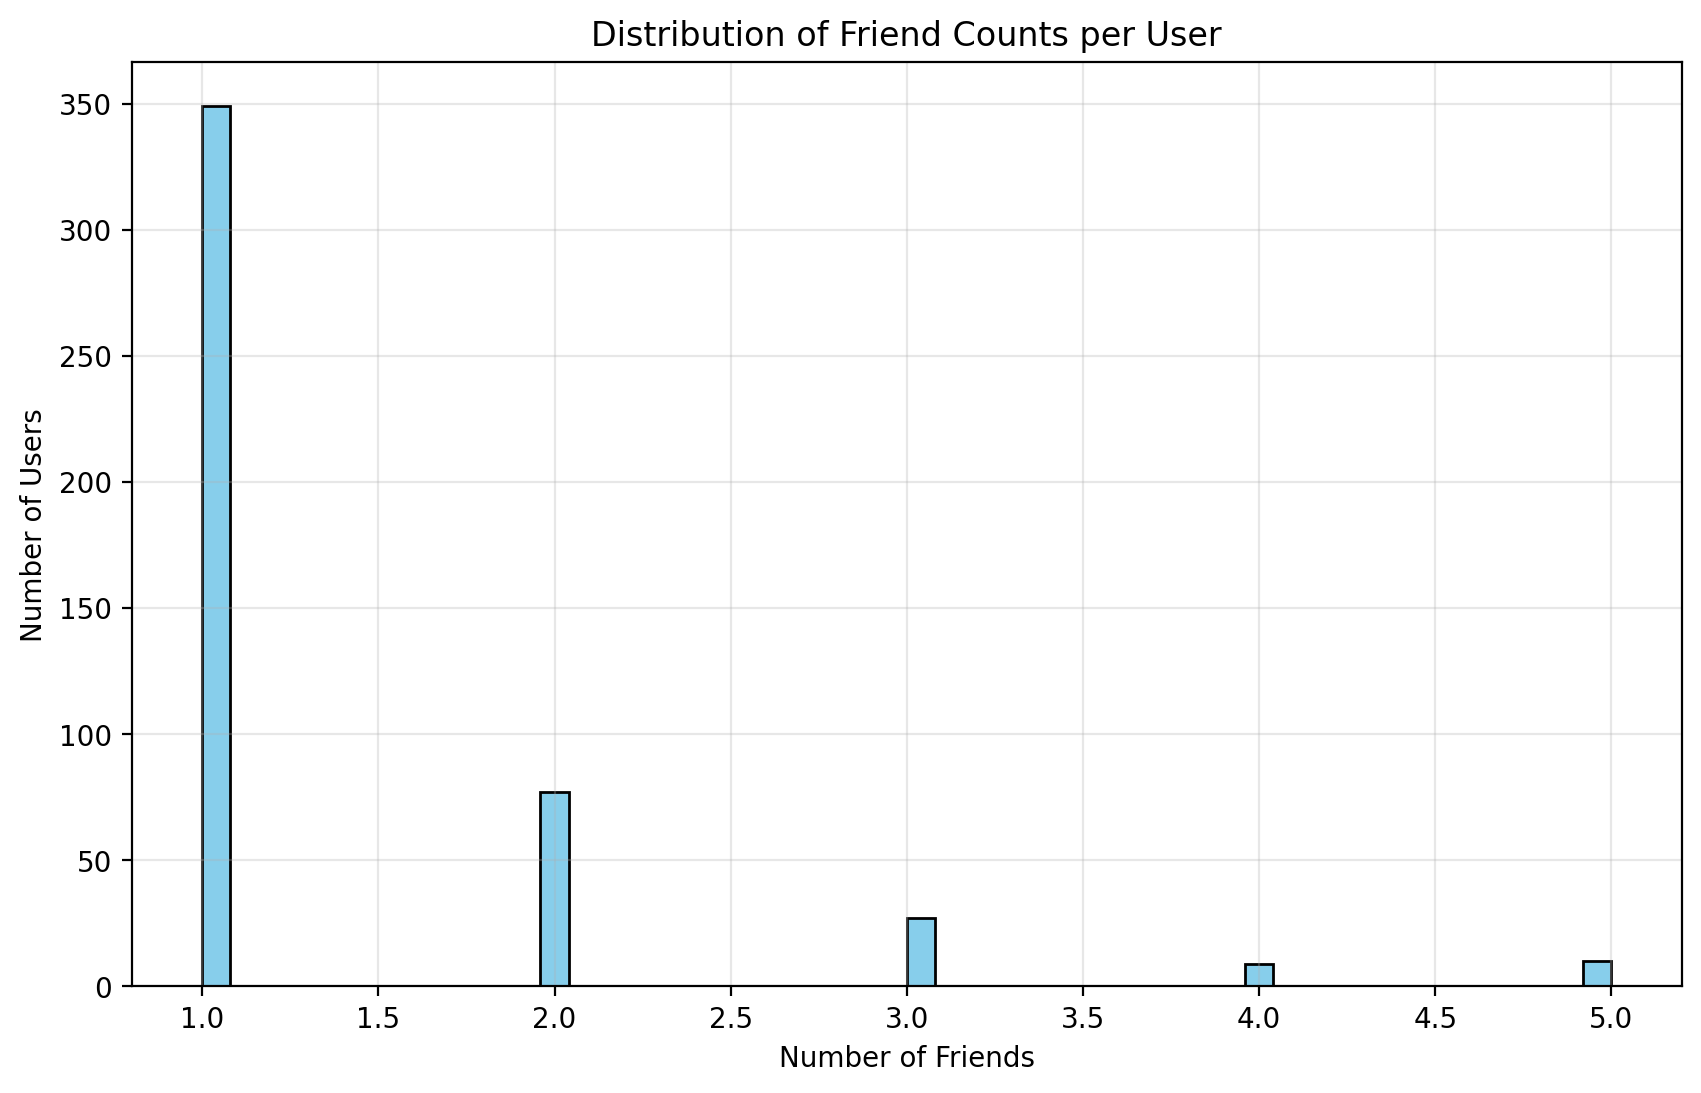

Top 10 user_ids appearing most in friend lists:
user_id: 3694, appears in 5 friend lists
user_id: 2187, appears in 5 friend lists
user_id: 1128, appears in 5 friend lists
user_id: 476, appears in 5 friend lists
user_id: 6164, appears in 5 friend lists
user_id: 5943, appears in 5 friend lists
user_id: 5250, appears in 5 friend lists
user_id: 6229, appears in 5 friend lists
user_id: 2219, appears in 5 friend lists
user_id: 962, appears in 5 friend lists


In [12]:
# --- Cleaning data ---

#Similarly to social_network we have to turn the friend_list column from string to list
if social_network['friend_list'].apply(lambda x: isinstance(x, list)).mean() < 1.0:
     social_network['friend_list'] =  social_network['friend_list'].str.strip('[]').str.split(',')

# If not already lists of integers, clean and convert
if social_network['friend_list'].apply(lambda x: all(isinstance(f, int) for f in x)).mean() < 1.0:
    social_network['friend_list'] = social_network['friend_list'].apply(
        lambda x: [int(f.strip()) for f in x if f.strip().isdigit()]
    )



# --- Analysing data ---

friend_counts = social_network['friend_list'].apply(len)

print("Average friends in list:", round(friend_counts.mean(), 2))
print("Median  friends in list:", friend_counts.median())
print("Max  friends in list:", friend_counts.max())

#Plot distribution of how many friends user typically have 
plt.figure(figsize=(10, 6))
plt.hist(friend_counts, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Friend Counts per User')
plt.xlabel('Number of Friends')
plt.ylabel('Number of Users')
plt.grid(True, alpha=0.3)
plt.show()

#Check who are the top 10 "influencers"
all_friends = [friend for sublist in social_network['friend_list'] for friend in sublist]
friend_freq = Counter(all_friends)
top_5_users = friend_freq.most_common(10)
print("Top 10 user_ids appearing most in friend lists:")
for user_id, count in top_5_users:
    print(f"user_id: {user_id}, appears in {count} friend lists")

## Inspecting user features
In this file each user is associated to a list of friends

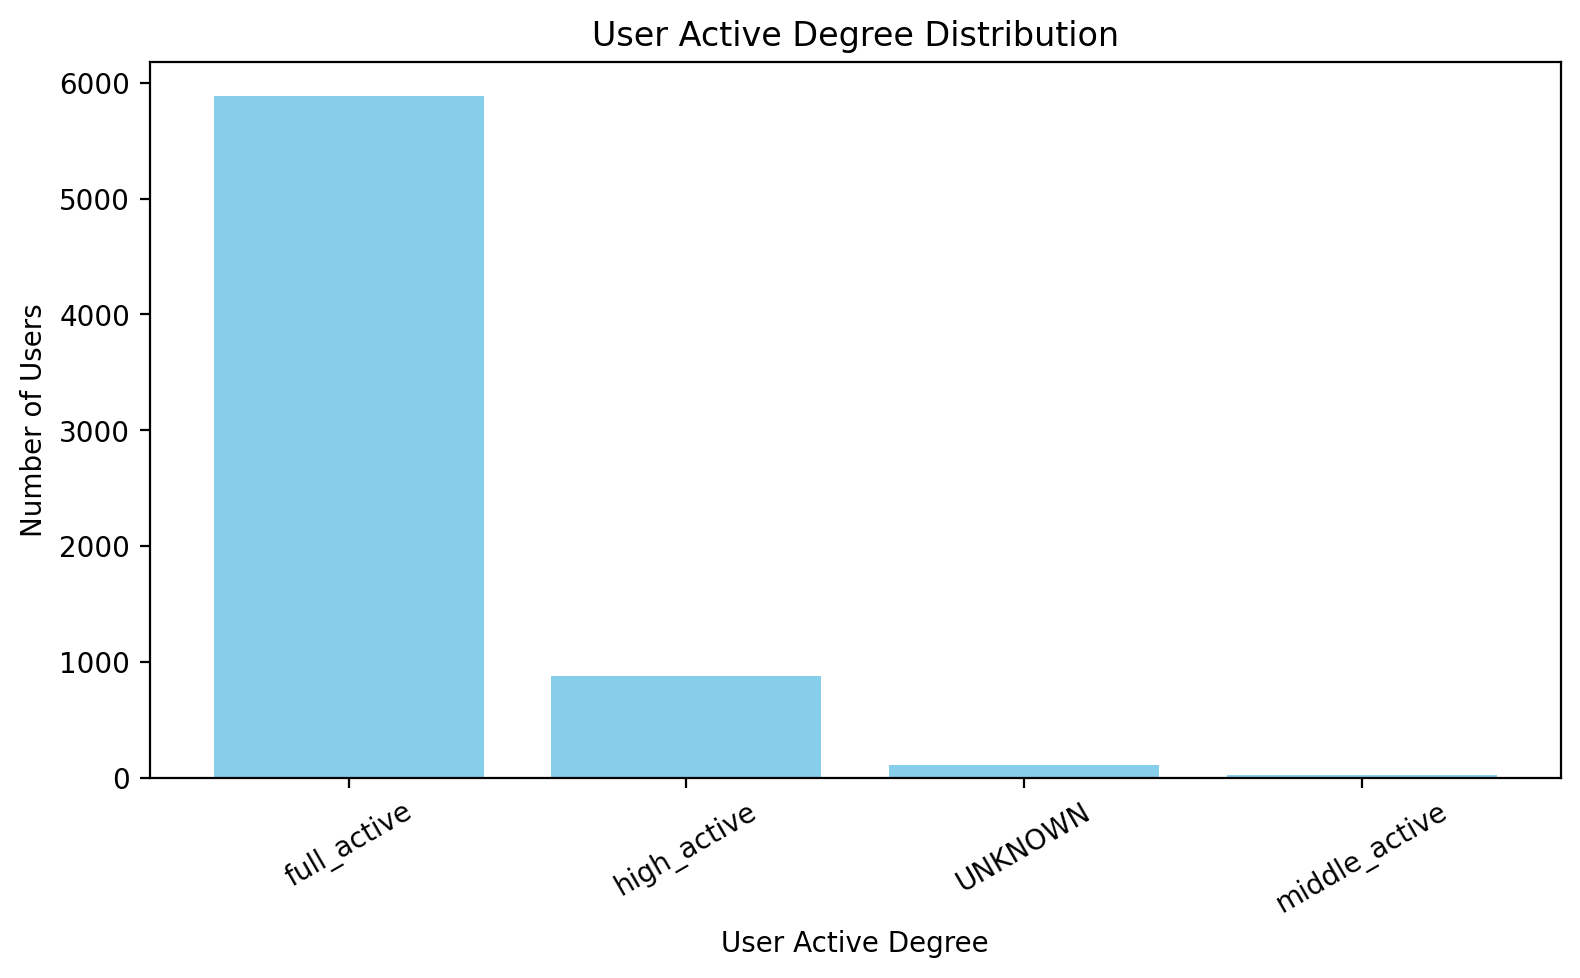

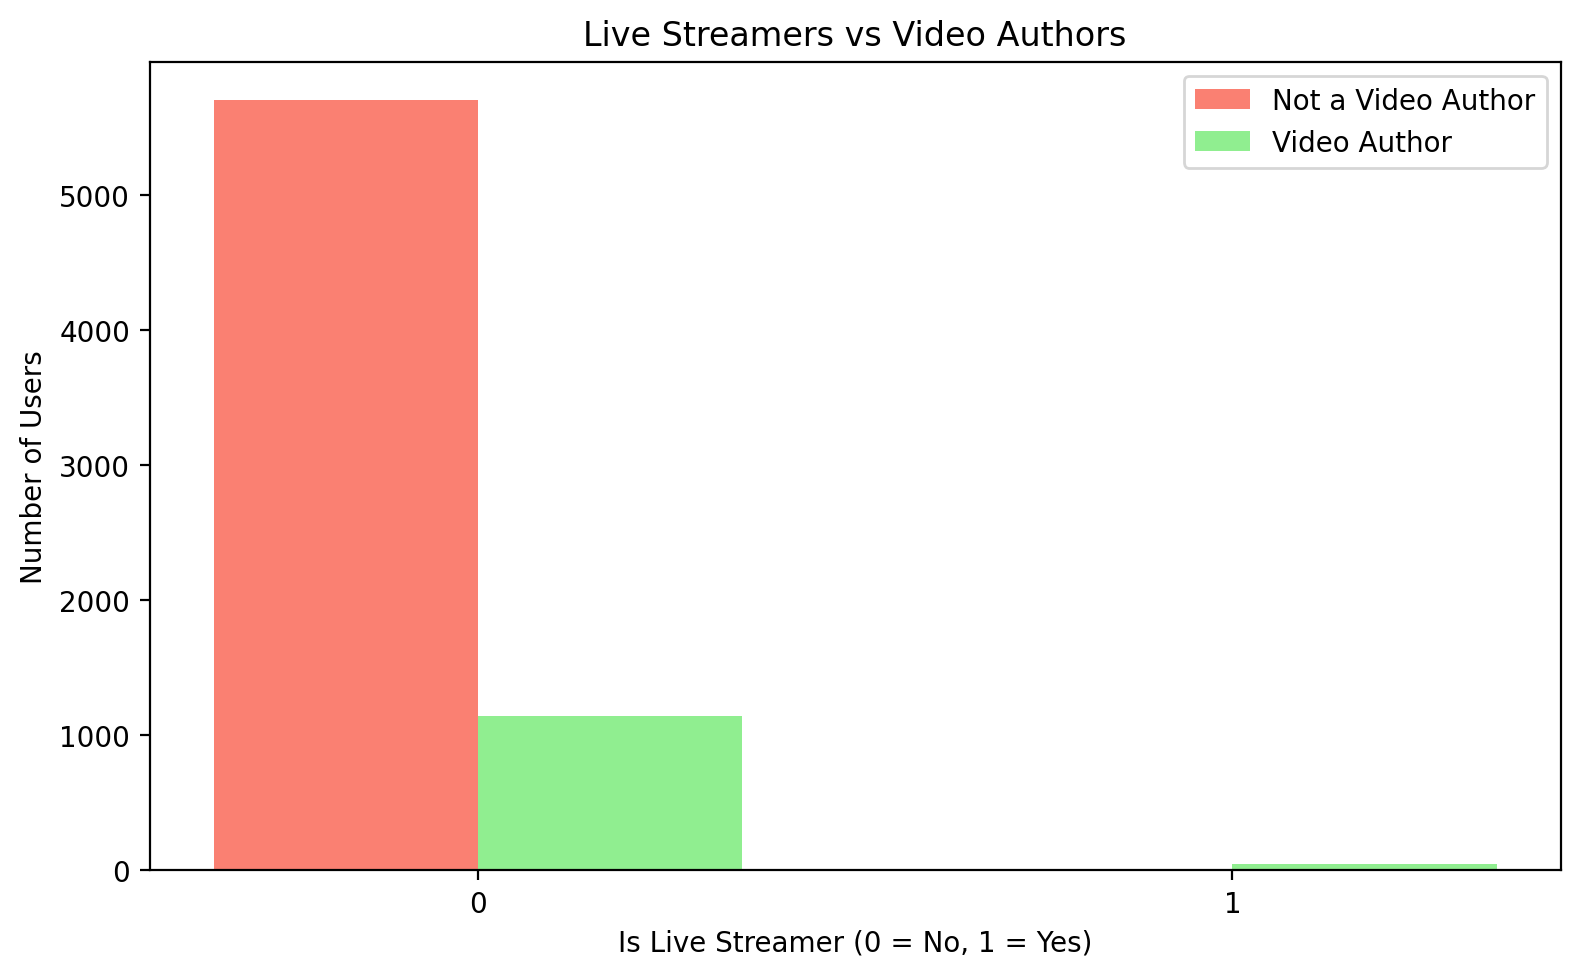

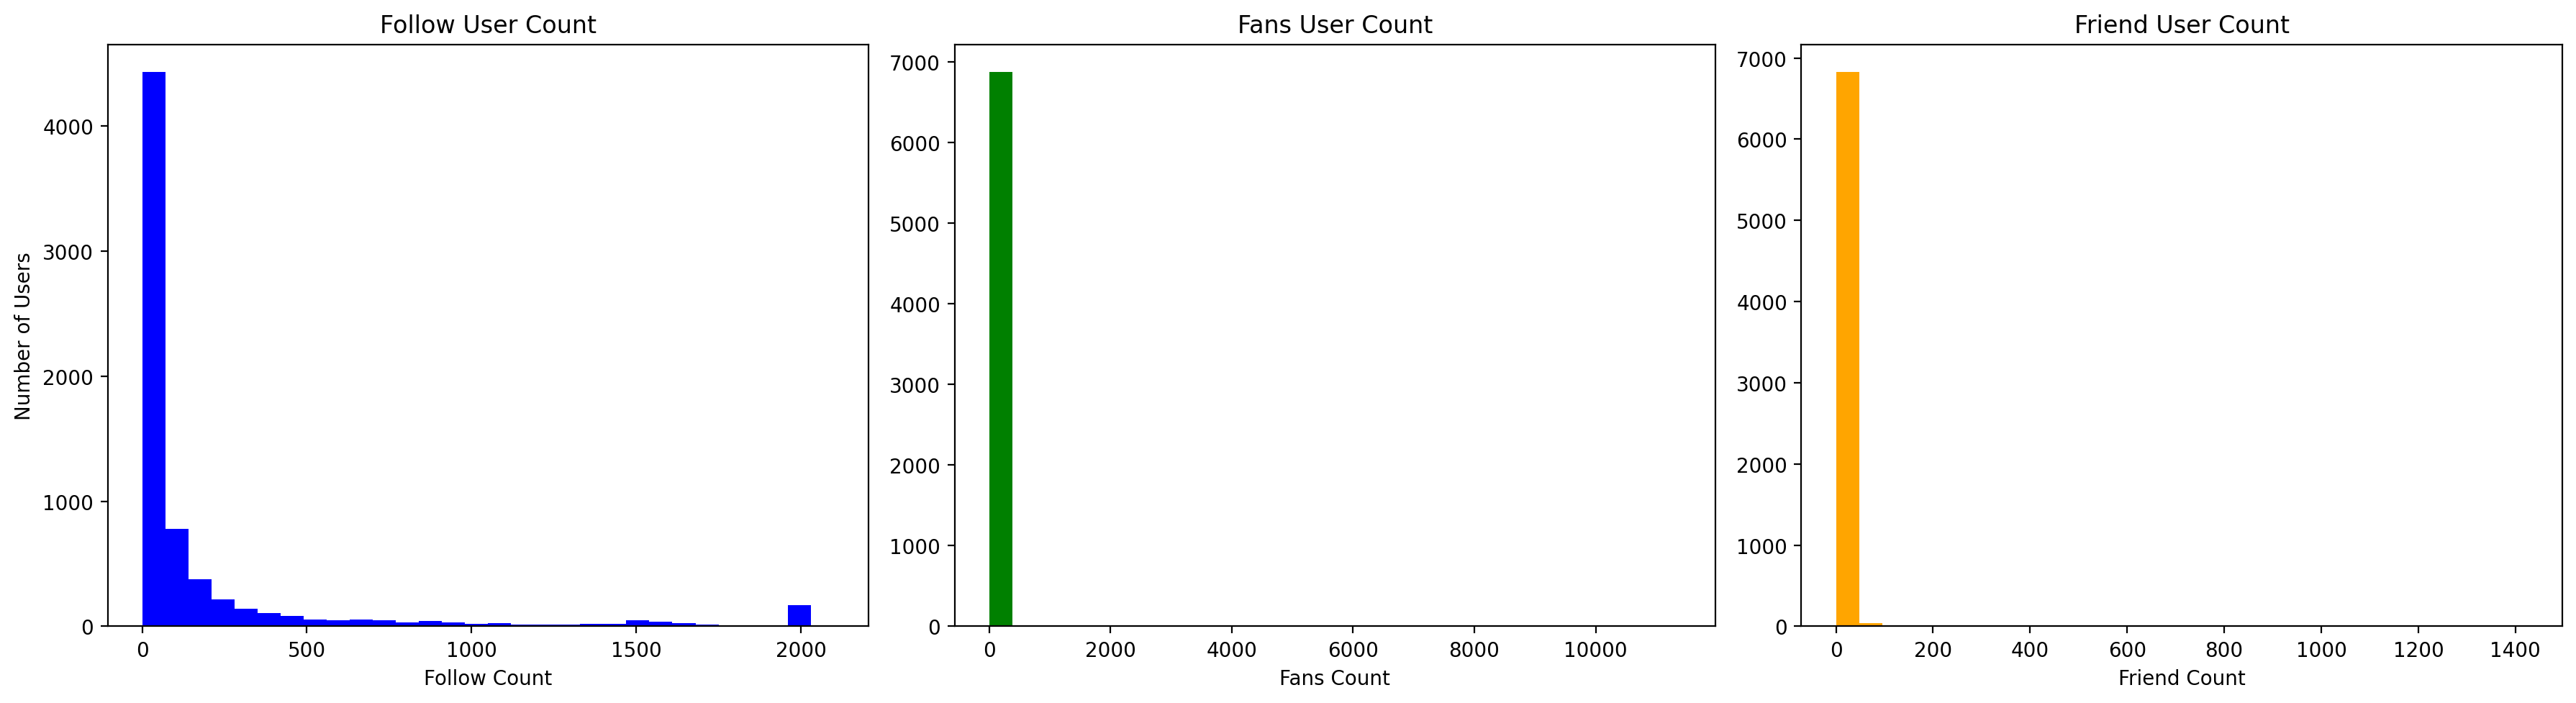

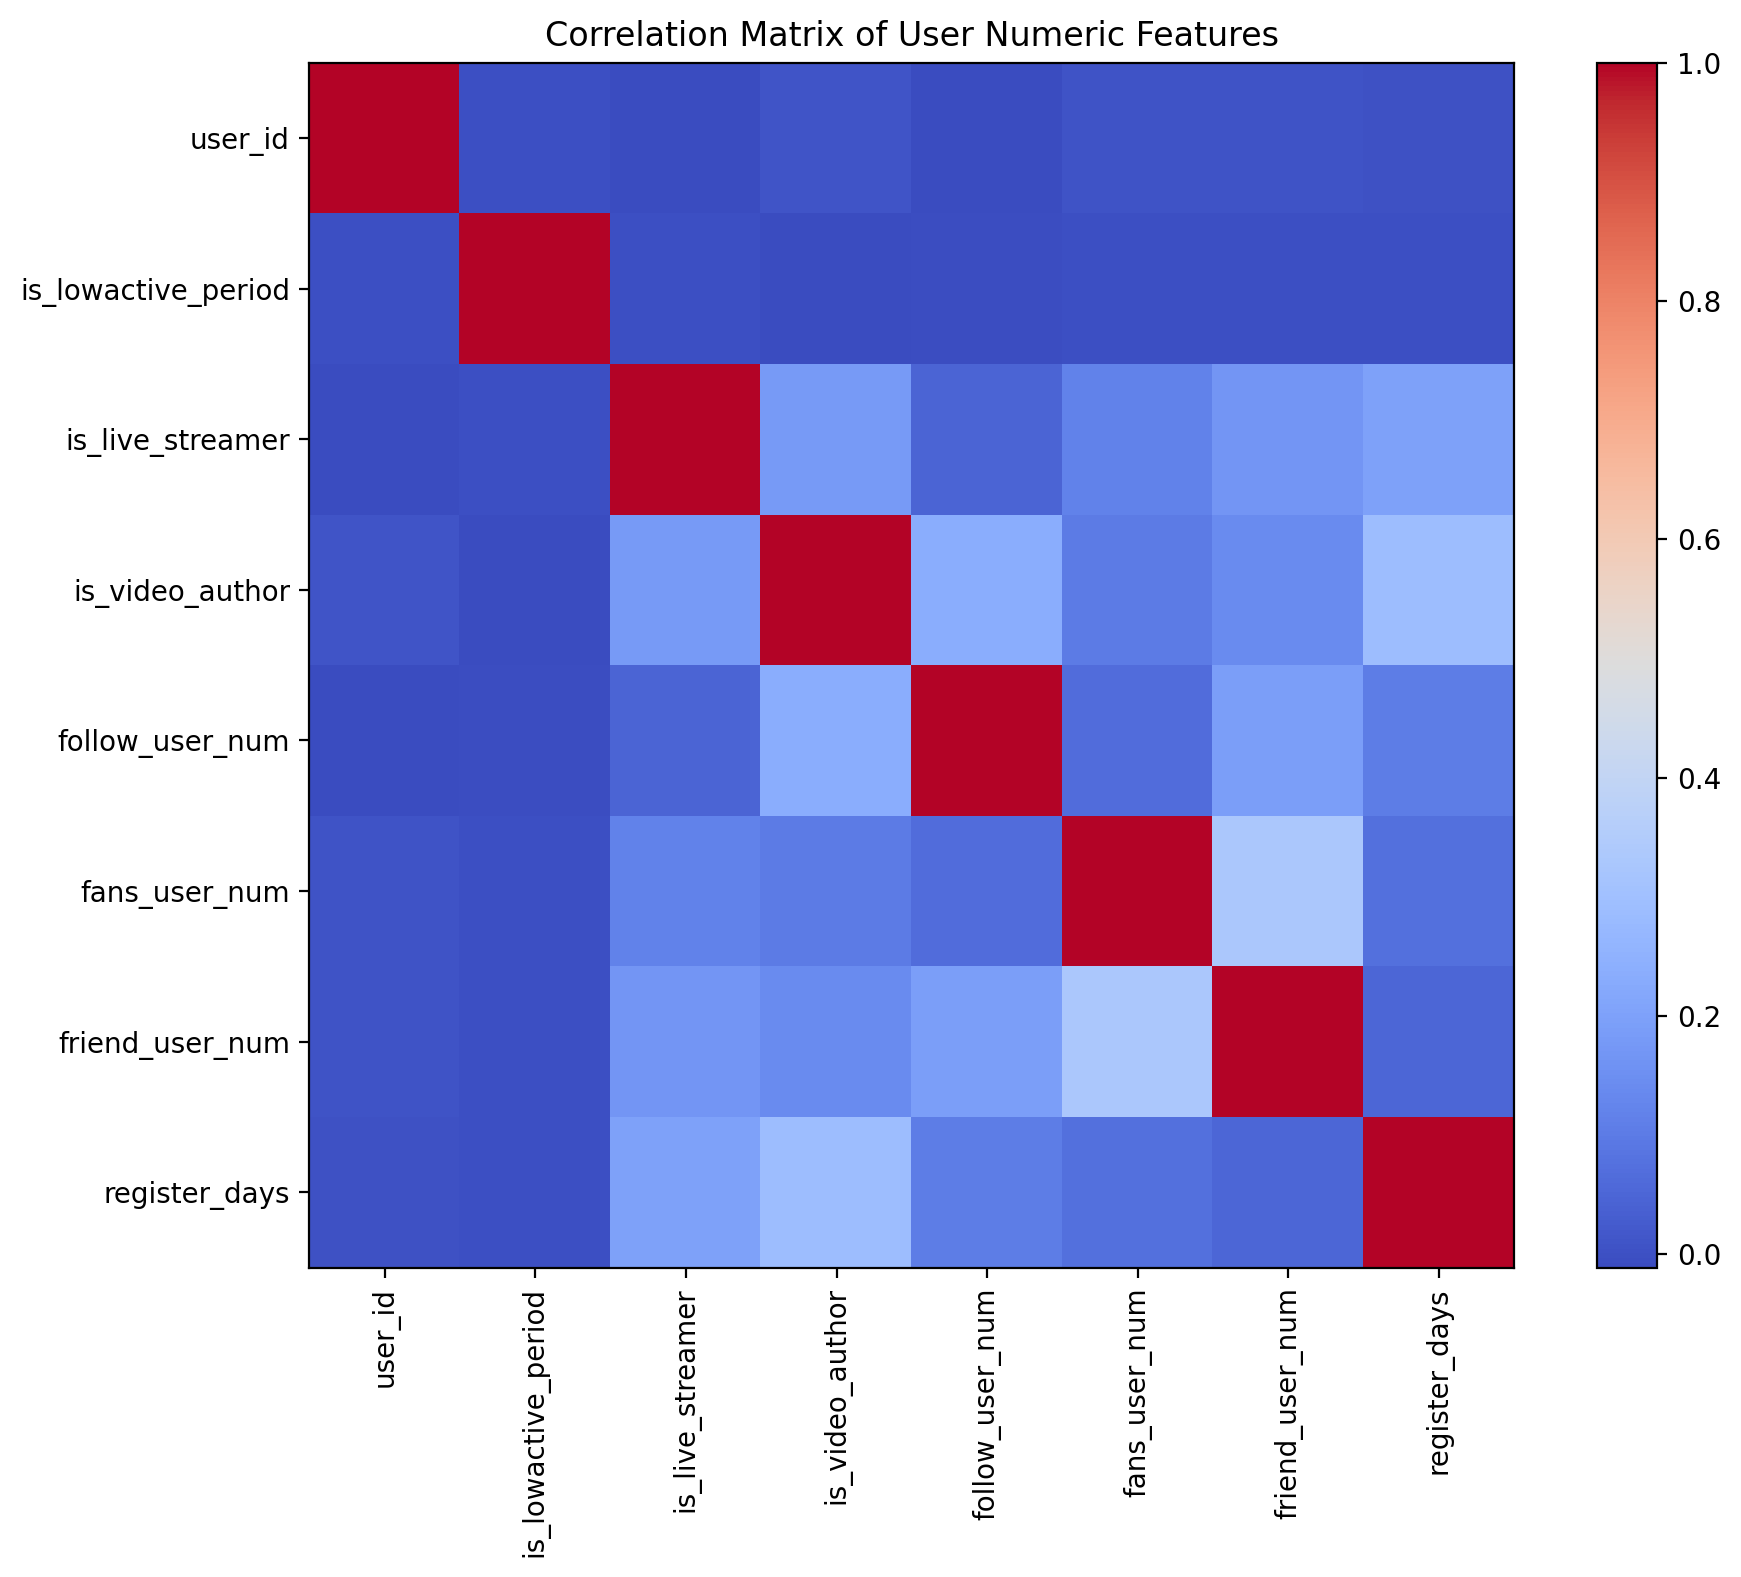

In [13]:


# --- Cleaning data ---

#there is a few column we won't be using to inspect the data so we remove them
columns_to_remove = ['onehot_feat0','onehot_feat1', 'onehot_feat2', 'onehot_feat3', 'onehot_feat4', 'onehot_feat5', 'onehot_feat6', 'onehot_feat7'
                   , 'onehot_feat8', 'onehot_feat9', 'onehot_feat10', 'onehot_feat11', 'onehot_feat12', 'onehot_feat13', 'onehot_feat14', 'onehot_feat15',
                   'onehot_feat16', 'onehot_feat17', 'friend_user_num_range', 'register_days_range', 'fans_user_num_range', 'follow_user_num_range']
columns_to_drop = [col for col in columns_to_remove if col in user_features.columns]
user_features = user_features.drop(columns=columns_to_drop)

user_features.tail(5)

# --- Analysing data ---

#User Active Degree Distribution
active_counts = user_features['user_active_degree'].value_counts()

plt.figure(figsize=(8, 5))
plt.bar(active_counts.index, active_counts.values, color='skyblue')
plt.title('User Active Degree Distribution')
plt.xlabel('User Active Degree')
plt.ylabel('Number of Users')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


#Live Streamers vs Video Authors
grouped = user_features.groupby(['is_live_streamer', 'is_video_author']).size().unstack(fill_value=0)

x = np.arange(len(grouped))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, grouped[0], width, label='Not a Video Author', color='salmon')
plt.bar(x + width/2, grouped[1], width, label='Video Author', color='lightgreen')

plt.title('Live Streamers vs Video Authors')
plt.xlabel('Is Live Streamer (0 = No, 1 = Yes)')
plt.ylabel('Number of Users')
plt.xticks(x, grouped.index)
plt.legend()
plt.tight_layout()
plt.show()


#Histograms of Follow / Fans / Friends Count
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].hist(user_features['follow_user_num'], bins=30, color='blue')
axs[0].set_title('Follow User Count')
axs[0].set_xlabel('Follow Count')
axs[0].set_ylabel('Number of Users')

axs[1].hist(user_features['fans_user_num'], bins=30, color='green')
axs[1].set_title('Fans User Count')
axs[1].set_xlabel('Fans Count')

axs[2].hist(user_features['friend_user_num'], bins=30, color='orange')
axs[2].set_title('Friend User Count')
axs[2].set_xlabel('Friend Count')

plt.tight_layout()
plt.show()


#Correlation Matrix
numeric_features = user_features.select_dtypes(include=['int64', 'float64'])
correlation = numeric_features.corr()

plt.figure(figsize=(10, 8))
plt.imshow(correlation, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xticks(range(len(correlation)), correlation.columns, rotation=90)
plt.yticks(range(len(correlation)), correlation.columns)
plt.title('Correlation Matrix of User Numeric Features')
plt.tight_layout()
plt.show()



## Save changes and cleaning to the .csv files

In [14]:
small_matrix.to_csv(rootpath + "data/small_matrix.csv", index=False)
big_matrix.to_csv(rootpath + "data/big_matrix.csv", index=False)
item_categories.to_csv(rootpath + "data/item_categories.csv", index=False)
user_features.to_csv(rootpath + "data/user_features.csv", index=False)
item_daily_features.to_csv(rootpath + "data/item_daily_features.csv", index=False)
kuairec_caption_category.to_csv(rootpath + "data/kuairec_caption_category.csv", index=False)
social_network.to_csv(rootpath + "data/social_network.csv", index=False)